# **Group 5 Assigment**

________________________________________________________________________________________________________________________________________________
## **Global approach**
Our task is to estimate the total power consumption per hour fromm the 01-08-2017 to 01-11-2017 in several regions of Spain. For this porpoise, a set of data was given with some variables shown below. The process to estimate the power will be the following:

> 1. Visualize the given data and analyze it.
> 2. Transform the given data so it can be manipulated and turned into useful variables that suit the problem task.
> 3. Feautre engineering to add more meaningful variables to the data set in order to increase the accuracy of the prediction.
> 4. Test the created model by means of splitting the known data to obtain and accuracy for the model so it can be used in the final prediction.
> 5. Prediction of the power rates in the specified dates, by means of appliying the same feature engineering to the date range.
> 6. Write the results in a csv


In [131]:
from suntime import Sun
import datetime as dt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
import sklearn.linear_model as linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.ar_model import AR
from statistics import mean

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

import seaborn as sns
from xgboost import XGBRegressor



### **1- Data Visualization**

In [132]:
# Read dataset
d = pd.read_csv('Consumptions.csv',sep=';')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591731 entries, 0 to 3591730
Data columns (total 6 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   CUPS     object
 1   ZipCode  int64 
 2   Rate     object
 3   Date     object
 4   Hour     int64 
 5   Value    int64 
dtypes: int64(3), object(3)
memory usage: 164.4+ MB


In [133]:
d.head()

,CUPS,ZipCode,Rate,Date,Hour,Value
0,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,1,502
1,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,2,418
2,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,3,418
3,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,4,418
4,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,5,418


In [134]:
# Check Number of null values in the columns: none, so the set is full
d.isnull().sum()

CUPS       0
ZipCode    0
Rate       0
Date       0
Hour       0
Value      0
dtype: int64

So far, there are 6 variables in the data set. Each row contains each consumer consumption per hour in the company, besides other data. However the interesring topics to be studied and predicted in this work have to be obtained in a different manner using the above mentioned variables. It is of our interset to compute the total consumption per hour. In addition, it seems interesting to know what is the variation of power users in the company thoughout the data range. For this porpoise, the total daily power, hourly power and number of users through the data range will be shown.

Text(0.5, 1.0, 'Hourly total power')

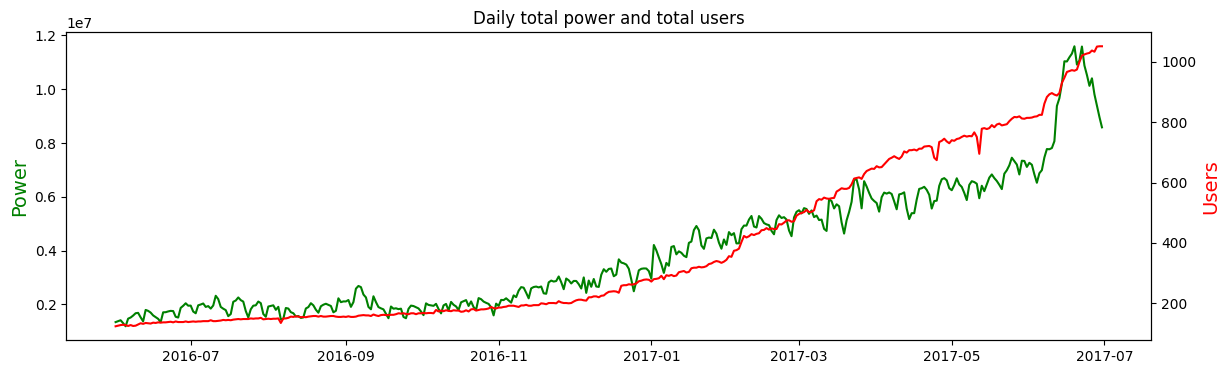

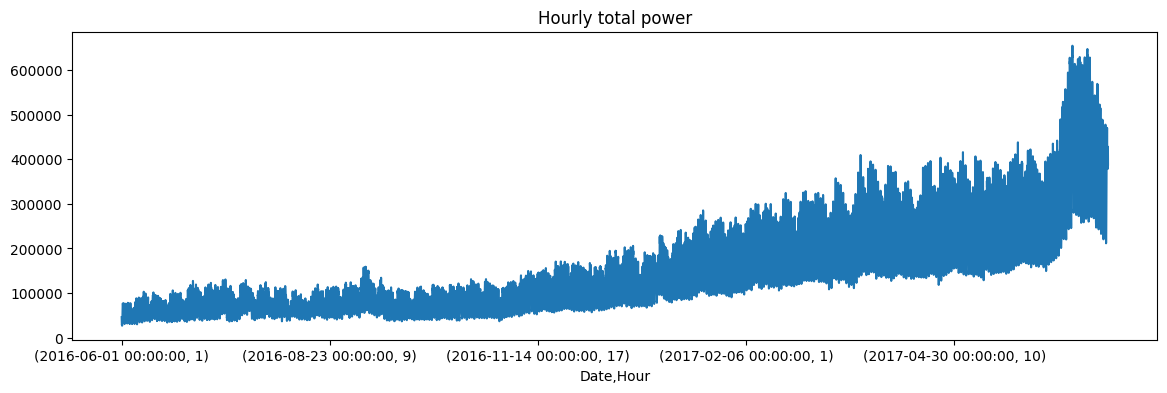

In [135]:
# Convert data column to a datetime with year/month/day format and specify the frequency of the datetime for the forecaster
d['Date'] = pd.to_datetime(d['Date'], format='%Y/%m/%d')

df = d.groupby(['Date'])['Value'].sum()
users = d.groupby(['Date'])['CUPS'].nunique().to_list()

fig, ax = plt.subplots(figsize=(14, 4))
ax2 = ax.twinx()
ax.plot(df.index.to_list(),df,color='green')
ax2.plot(df.index.to_list(),users,color='red')
ax.set_ylabel("Power",color="green",fontsize=14)
ax2.set_ylabel("Users",color="red",fontsize=14)
plt.title('Daily total power and total users')

fig, ax = plt.subplots(figsize=(14, 4))
d.groupby(['Date','Hour'])['Value'].sum().plot()
plt.title('Hourly total power')

As a consequence of this visualization,it can be firstly seen that the correlation between the number of users and the consumption is quite high. From november onwards, the number of consumers increases rapidly, what rockets the consumption of energy. Secondly, a peek in June 2017 is noticed. This peek is due to an extreme heat wave that occured in Spain that month. This raises two possibilities:

    - The June'17 data could be deleted because the data is not representative and produces noise in the model.
    - That same data could be used to train the model if a temperature dataframe is obtained, so that the model finds a correlation between temperature and power peaks

The latter is chosen, since there was data available and the complexity of introducing this effect is not high. Besides, this would make the model more accurate as adding a meaningful variable like temperature could help predict future power consumptions based on temperature estimations.

Now there is an overview of the data available, several transformations would be carried out to input this variables in the model.

### **2- Data Transformations**

Because we are to predict the total power consumption, and the CUPS and zip code have nothing to do with total power consumption, these variables will be discarded, and a data set with the total power per day will be created, by grouping per hour and date.

In [136]:
df=d.groupby(['Date','Hour'])['Value'].sum().to_frame()

A list with the total number of users of each day, is also obtained since it will be added later to the dataframe.

In [137]:
users = d.groupby(['Date','Hour'])['CUPS'].nunique().to_list()

A list with the dates is also created to be appended to the dataframe.

In [138]:
date = []
hour = []
for index in df.index:
    date.append(index[0])
    hour.append(index[1])

# Re index the df dataframe
df['Index'] = [idx for idx in range(len(df))]
df = df.set_index('Index')


### **3- Feature engineering**
This may be the most important step of the process. Since only few variables given in the dataset are meaningful, some other variables should be created in order to better estimate the behaviour of the power consumption in the country, the variables created are: 

    -Month

    -Day of the month

    -Whether it is a workday or weekend

    -Which week of the month it is

    -The cummulative workday in each month

    -Season
    
    -Daylight hours per day

    -Whether it is day or night at a given hour

    -Whether it is festivity or not

    - Mean/max/min temperature at each hour
    
    
 This variables are expected to have much more importance in the model learning phase, nevertheless, their correlation will be later analyzied.


In [139]:
def getSeason(month):
    if (month == 12 or month == 1 or month == 2):
       return 'Winter'
    elif(month == 4 or month == 5  or month == 3):
       return 'Spring'
    elif(month ==6 or month==7 or month == 8):
       return 'Summer'
    else:
       return 'Autumn'

def getDaylighthours(year,month,day):

   sun = Sun(36.7, -6.11)

   # On a special date in your machine's local time zone
   abd = dt.date(year,month,day)
   abd_sr = sun.get_local_sunrise_time(abd)
   abd_ss = sun.get_local_sunset_time(abd)
   diff = abd_ss-abd_sr
   return round(diff.total_seconds()/3600)

def isDay(year,month,day,hour):
   # Get the sun in a location (Jerez)
   sun = Sun(36.7, -6.11)
   abd = dt.date(year,month,day)
   abd_sr = sun.get_local_sunrise_time(abd)
   abd_ss = sun.get_local_sunset_time(abd)

   return hour>abd_sr.hour and hour < abd_ss.hour

def isWorday(day):
   if day == 1 or day == 2 or day == 3 or day == 4 or day == 5:
      return 1
   else:
      return 0

def isFestive(year,month,day):
   date = str(year)+'-'+str(month)+'-'+str(day)
   festives = {'2016-01-01','2016-01-06','2016-03-25','2016-08-15','2016-10-12','2016-11-01','2016-12-06','2016-12-08',
               '2017-01-01','2017-01-06','2017-03-25','2017-08-15','2017-10-12','2017-11-01','2017-12-06','2017-12-08'}
   if date in festives:
      return 1
   else:
         return 0

df['Date'] = pd.to_datetime(date)
df['Hour'] = hour
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day

seasons = []
daylight = []
isday=[]
iswork=[]
isfestive = []
for index in range(len(df.index)):
   seasons.append(getSeason(df['Month'][index]))
   daylight.append(getDaylighthours(df['Year'][index],df['Month'][index],df['Day'][index]))
   isday.append(isDay(df['Year'][index],df['Month'][index],df['Day'][index],df['Hour'][index]))
   iswork.append(isWorday(df['Day'][index]))
   isfestive.append(isFestive(df['Year'][index],df['Month'][index],df['Day'][index]))



# df['Workday_N'] = np.busday_count(df['Date'].values.astype('datetime64[M]'),df['Date'].values.astype('datetime64[D]'))
df['Week_day'] = df['Date'].dt.weekday
# df['Week_of_month'] = (df['Date'].dt.day- df['Date'].dt.weekday - 2) // 7 + 2
df['Season'] = seasons
df['Users'] = users
df['Daylight_hours'] = daylight
df['isFestive'] =isfestive
df['isDay'] = isday
df['isWorday'] = iswork

# Encode Seasons
df = pd.get_dummies(df)

df.head()


,Value,Date,Hour,Month,Year,Day,Week_day,Users,Daylight_hours,isFestive,isDay,isWorday,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
Index,,,,,,,,,,,,,,,,
0,46257,2016-06-01,1,6,2016,1,2,124,15,0,False,1,0,0,1,0
1,32488,2016-06-01,2,6,2016,1,2,124,15,0,False,1,0,0,1,0
2,28666,2016-06-01,3,6,2016,1,2,124,15,0,False,1,0,0,1,0
3,29334,2016-06-01,4,6,2016,1,2,124,15,0,False,1,0,0,1,0
4,27025,2016-06-01,5,6,2016,1,2,124,15,0,False,1,0,0,1,0


#### ***3.1- Temperature model visualization***

As aforementioned, the temperature would also need to be introduced to help correlate the peaks of power consumption to temperature increases and improve the model. Firstly, a data set of weather information obtained from Kaggle is loaded (https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?resource=download):

In [140]:
weather = pd.read_csv('weather_features.csv')
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


It can be seen that the hourly temperature per hour is given in several cities (Madrid, Bilbao, Barcelona, Valencia, Sevilla), what gives a good information about the mean temperature around Spain. The dataframe begins in 2015 and ends in 2018, so some transformations should be done. Out of all the variables shown above, the one interesting for the prediction is the 'temp' column, which seems to be in Kelvin. 

#### ***3.2- Temperature data transformation***
Firstly, the dates are transformed to date time format so they can better treated, just like it was done with the power data set.

In [141]:
date = []
hour = []
for date_and_hour in weather['dt_iso']:
    date.append(date_and_hour[0:10])
    hour.append(date_and_hour[11:13])

weather['Date'] = date
weather['Hour'] = hour

# Taking the required columns only
df_weather = weather[['dt_iso', 'Date', 'Hour', 'city_name', 'temp','temp_max','temp_min']]
hours = []
# Changing the hour format from ## to #
for hour in df_weather['Hour']:
    if hour == '00':
        hour = '24'
    hours.append(hour.lstrip('0'))

weather['Hour'] = hours
# Transforming the hour's type from object to integer
weather['Hour'] = weather['Hour'].astype(int)

# Transforming the date to date times
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')


#### ***3.3- Temperature data fitering***

Now the dates are ready to be treated, they are filtered for the problem's date range.

In [142]:
df_weather = df_weather.loc[(df_weather['Date'] >= '2016-06-01') & (df_weather['Date'] < '2017-07-01')]
df_weather_predictor = weather.loc[(weather['Date'] >= '2017-08-01') & (weather['Date'] < '2017-11-02')]

And the mean of the temperatures per hour is computed out of all the 5 available cities. Then, a conversion from Kelvin to Celcius is performed.

In [143]:
# Compute the means
df_weather = df_weather.groupby(['Date', 'Hour'])['temp','temp_max','temp_min'].mean()
df_weather_predictor = df_weather_predictor.groupby(['Date', 'Hour'])['temp','temp_max','temp_min'].mean()
# Kelvin to Celsius
df_weather = (df_weather-273).round()
df_weather_predictor = (df_weather_predictor-273).round()

# Adding the temperature to the dataframe
df['Temperature_mean'] = list(df_weather['temp'])
df['Temperature_max'] = list(df_weather['temp_max'])
df['Temperature_min'] = list(df_weather['temp_min'])

df = df.reindex(sorted(df.columns), axis=1)
df.head()

C:\Users\rodri\AppData\Local\Temp\ipykernel_22204\207101435.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_weather = df_weather.groupby(['Date', 'Hour'])['temp','temp_max','temp_min'].mean()
C:\Users\rodri\AppData\Local\Temp\ipykernel_22204\207101435.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_weather_predictor = df_weather_predictor.groupby(['Date', 'Hour'])['temp','temp_max','temp_min'].mean()


,Date,Day,Daylight_hours,Hour,Month,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Temperature_max,Temperature_mean,Temperature_min,Users,Value,Week_day,Year,isDay,isFestive,isWorday
Index,,,,,,,,,,,,,,,,,,,
0,2016-06-01,1,15,1,6,0,0,1,0,19.0,18.0,16.0,124,46257,2,2016,False,0,1
1,2016-06-01,1,15,2,6,0,0,1,0,20.0,17.0,14.0,124,32488,2,2016,False,0,1
2,2016-06-01,1,15,3,6,0,0,1,0,19.0,16.0,13.0,124,28666,2,2016,False,0,1
3,2016-06-01,1,15,4,6,0,0,1,0,19.0,15.0,11.0,124,29334,2,2016,False,0,1
4,2016-06-01,1,15,5,6,0,0,1,0,18.0,14.0,11.0,124,27025,2,2016,False,0,1


#### ***3.4- Analyzing the correlation of the new new variables***

C:\Users\rodri\AppData\Local\Temp\ipykernel_22204\3006120814.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['Value'].sort_values(ascending=False)


Text(0.5, 1.0, 'Variable correllation with Power consumption')

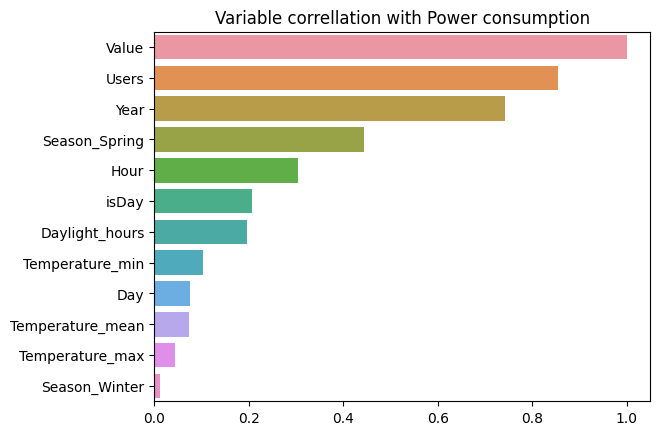

In [144]:
# Correlation of new columns
correlations = df.corr()['Value'].sort_values(ascending=False)
meaningful_vars = []
corr = []
for i in range(len(correlations.index)):
    meaningful_vars.append(correlations.index[i])
    corr.append(correlations[i])
sns.barplot(x=corr, y=meaningful_vars)
plt.title('Variable correllation with Power consumption')

Out of this figure, some considerations are drawn:

    - The new variables seem to have good correlation with the power consumption value, thus they will remain in the set.

    - The number of users in the network seems to be the most important factor in the demand of power.

    - External factors like seasonality and number of light hours per day seem also to have a good impact on the behaviour of power demand.


### **4- Model testing**
Before predicting the required dates, a test will be performed to check how the model prepared so far works on known data. Thus, a split is performed between the date range available.
#### ***4.1- Test splitting***


In [145]:
# Drop the Date column because it is no longer needed
dates_train = df['Date']
df = df.drop('Date',axis=1)

# datos_train,datos_test = train_test_split(df,test_size=0.3)
datos_train = pd.concat([df.iloc[:2000],df.iloc[3000:]])
datos_test = df.iloc[2000:3000]
date_train = dates_train[datos_train.index.to_list()]
date_test = dates_train[datos_test.index.to_list()]

#### ***4.2- Training the model***


In [146]:
X = datos_train.drop(['Value'],axis = 1)
Y = datos_train['Value']
y = datos_test['Value']
x = datos_test.drop(['Value'],axis = 1)
# X = df.drop(['Value'],axis = 1)
# Y = df['Value']

# Regressor model:
forecaster = GradientBoostingRegressor(n_estimators = 700, max_depth = 18, max_leaf_nodes = 13)
forecaster.fit(X,Y)

GradientBoostingRegressor(max_depth=18, max_leaf_nodes=13, n_estimators=700)

#### ***4.3- Testing the model***

In [147]:
predicciones = forecaster.predict(x)
print(metrics.r2_score(y,predicciones))

0.7480598647570835


#### ***4.4- Visualizing the model***

C:\Users\rodri\AppData\Local\Temp\ipykernel_22204\1377269942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_test['Date'] = date_test


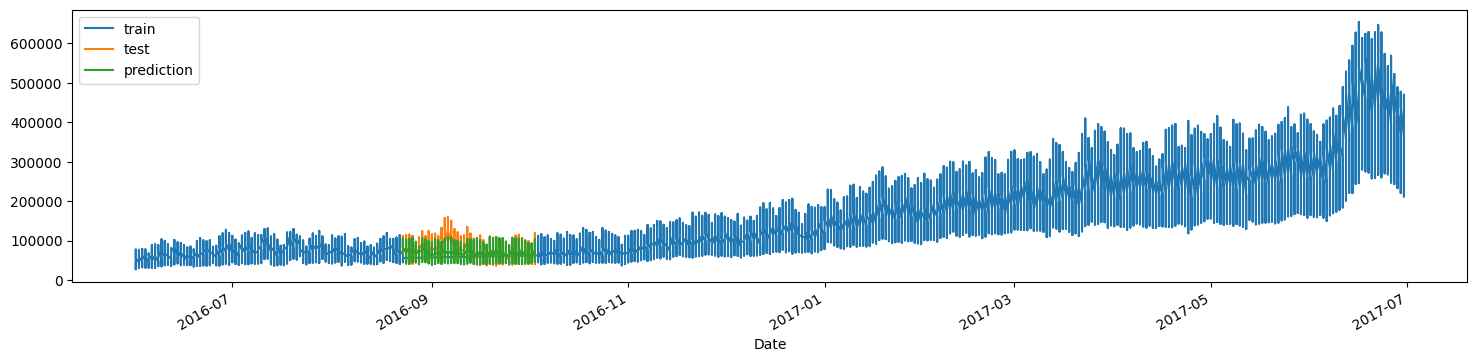

In [148]:
predicciones = pd.DataFrame({'Date':date_test,'Value':predicciones})
predicciones = predicciones.set_index('Date')

datos_train['Date'] = date_train
datos_test['Date'] = date_test
datos_train = datos_train.set_index('Date')
datos_test = datos_test.set_index('Date')

fig, ax = plt.subplots(figsize=(18, 4))
datos_train['Value'].plot(ax=ax, label='train')
datos_test['Value'].plot(ax=ax, label='test')
predicciones['Value'].plot(ax=ax, label='prediction')
ax.legend();

A very good accuracy is obtained, near 0.9 in almost all the split combinations tried, what suggests that the model performs quite good. It is important that the June'17 month is included in the train split so that the model correlates temperatures to higher peaks of power demand and therefore, apply this knowledge in the predictions. For this reason the heat wave month will be included in the model to predict the power the next autumn.

### **5- Predict the data from the 2017-08-01 to 2017-11-01**

#### ***5.1- Date range and new data frame for the predicted variables***

In [149]:
# Create the date range
date_range = pd.date_range(start='2017-08-01', end='2017-11-02',freq='H')
# Create the data set
df_predict = pd.DataFrame(date_range,columns=['Date'])
df_predict = df_predict[:-1]

#### ***5.2- Feature engineering to the new dataframe***

In [150]:
# Load the same variables as in the train dataframe
df_predict['Hour'] = df_predict['Date'].dt.hour
df_predict['Month'] = df_predict['Date'].dt.month
df_predict['Year'] = df_predict['Date'].dt.year
df_predict['Day'] = df_predict['Date'].dt.day

seasons = []
daylight = []
isday=[]
iswork=[]
isfestive = []
for index in range(len(df_predict.index)):
   seasons.append(getSeason(df_predict['Month'][index]))
   daylight.append(getDaylighthours(df_predict['Year'][index],df_predict['Month'][index],df_predict['Day'][index]))
   isday.append(isDay(df_predict['Year'][index],df_predict['Month'][index],df_predict['Day'][index],df_predict['Hour'][index]))
   iswork.append(isWorday(df_predict['Day'][index]))
   isfestive.append(isFestive(df_predict['Year'][index],df_predict['Month'][index],df_predict['Day'][index]))

df_predict['Season'] = seasons
df_predict['Week_day'] = df_predict['Date'].dt.weekday
# df_predict['Week_of_month'] = (df_predict['Date'].dt.day- df_predict['Date'].dt.weekday - 2) // 7 + 2
df_predict['Daylight_hours'] = daylight
df_predict['isDay'] = isday
df_predict['isWorday'] = iswork
df_predict['isFestive'] = isfestive
df_predict['Temperature_mean'] = list(df_weather_predictor['temp'])
df_predict['Temperature_max'] = list(df_weather_predictor['temp_max'])
df_predict['Temperature_min'] = list(df_weather_predictor['temp_min'])

date_test = df_predict['Date']
df_predict = df_predict.drop('Date',axis=1)

# Encode seasons
df_predict = pd.get_dummies(df_predict)
df_predict['Season_Spring'] = 0
df_predict['Season_Winter'] = 0


#### ***5.3- Predicting the users in this date range***

Text(0.5, 1.0, 'Users estimation for future dates')

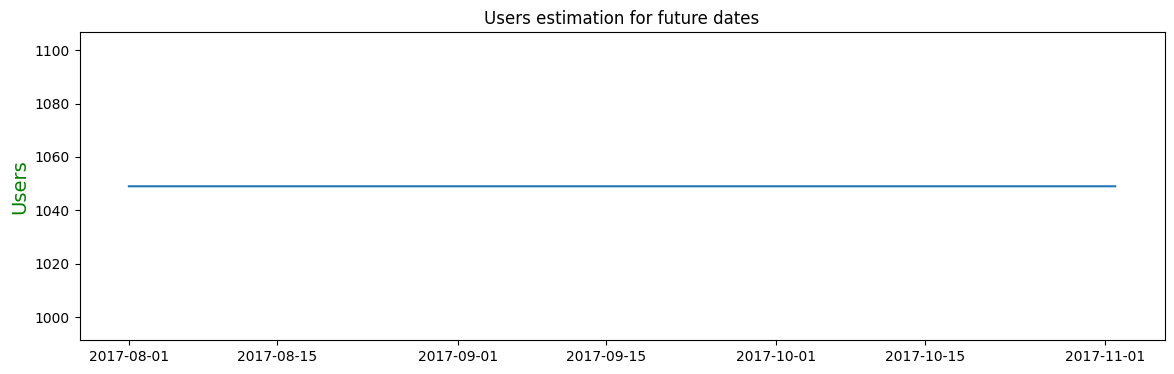

In [151]:
# users_model = linear_model.Ridge()
users_model =  GradientBoostingRegressor(n_estimators = 600, max_depth = 18, max_leaf_nodes = 13)
indeces = [idx for idx in range(len(df))]
indeces_test = [idx for idx in range(len(df)+31*24,len(df)+len(df_predict)+31*24)]
df['Index'] = indeces
df_predict['Index'] = indeces_test
# Training the model with the whole set
users_model.fit(df[['Index']],df['Users'])
users_prediction = users_model.predict(df_predict[['Index']]).round()


# Adding the list to the dataframe
df_predict['Users'] = users_prediction
df = df.drop('Index',axis=1)
df_predict = df_predict.set_index('Index')

df_predict = df_predict.reindex(sorted(df_predict.columns), axis=1)

users_prediction
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(date_range[:-1],users_prediction)
ax.set_ylabel("Users",color="green",fontsize=14)
plt.title('Users estimation for future dates')

#### ***5.4- Predicting the power in the date range***

C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


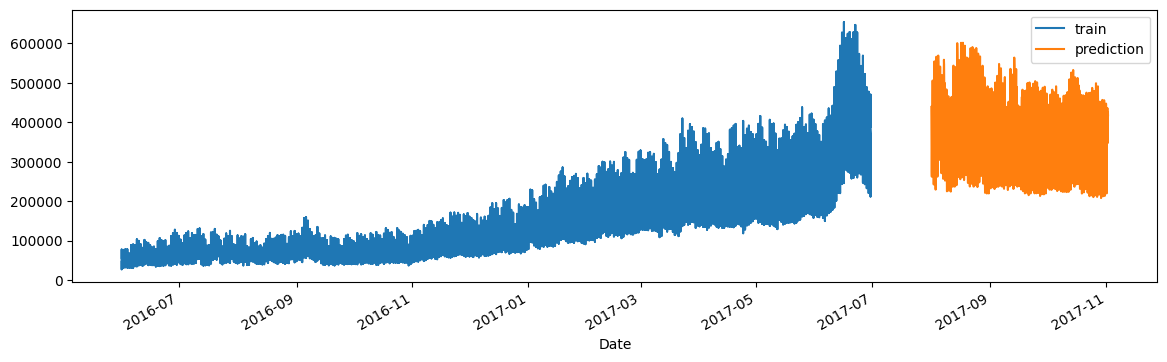

In [152]:
model = GradientBoostingRegressor(n_estimators = 600, max_depth = 18, max_leaf_nodes = 13)
model.fit(df.drop('Value',axis=1),df[['Value']])
predictions = model.predict(df_predict)

# predicciones = pd.DataFrame({'Index':df_predict.index.to_list(),'Value':predictions})
predicciones = pd.DataFrame({'Date':date_test,'Value':predictions})
predicciones = predicciones.set_index('Date')
df['Date'] = dates_train
df =df.set_index('Date')

fig, ax = plt.subplots(figsize=(14, 4))
df['Value'].plot(ax=ax, label='train')
predicciones['Value'].plot(ax=ax, label='prediction')
ax.legend();

### **6- Writing the files**


In [153]:
predicciones['Date'] = date_range[:-1]
predicciones['Hour'] = predicciones['Date'].dt.hour
predicciones.to_csv('Data_analysis_Group_5_predictions.csv', index=False)